
----- Высокий приоритет -----
  Макс: 9.79093 мс.
  Мин: 0.00311 мс.
  Среднее: 1.28338 мс.

----- Низкий приоритет -----
  Макс: 23.15756 мс.
  Мин: 0.00801 мс.
  Среднее: 1.31712 мс.

----- Обычный запуск -----
  Макс: 41.16306 мс.
  Мин: 0.00114 мс.
  Среднее: 2.00597 мс.

----- Планировщик SCHED_BATCH -----
  Макс: 20.26886 мс.
  Мин: 0.00192 мс.
  Среднее: 1.63377 мс.

----- Планировщик SCHED_FIFO -----
  Макс: 16.02450 мс.
  Мин: 0.00285 мс.
  Среднее: 0.95466 мс.

----- Планировщик SCHED_IDLE -----
  Макс: 9.36210 мс.
  Мин: 0.00745 мс.
  Среднее: 1.20158 мс.

----- Планировщик SCHED_NORMAL-OTHER -----
  Макс: 69.36455 мс.
  Мин: 0.00565 мс.
  Среднее: 2.37530 мс.

----- Планировщик SCHED_RR -----
  Макс: 18.74743 мс.
  Мин: 0.00239 мс.
  Среднее: 1.87247 мс.

----- Нагрузка на HDD -----
  Макс: 35.05833 мс.
  Мин: 0.00021 мс.
  Среднее: 1.42230 мс.

----- Нагрузка на сеть -----
  Макс: 13.16306 мс.
  Мин: 0.00044 мс.
  Среднее: 2.17121 мс.


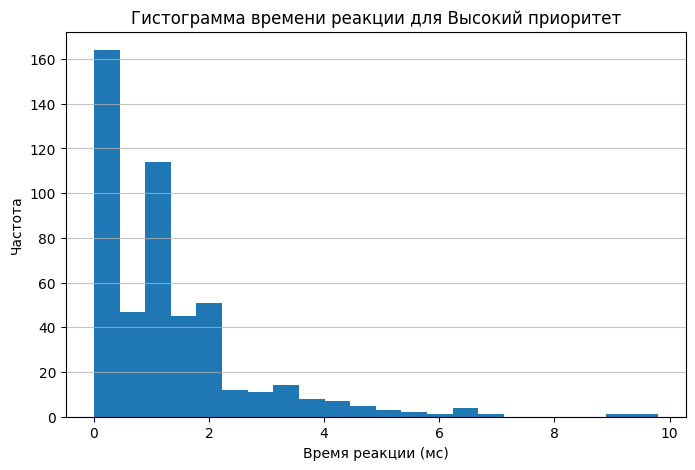

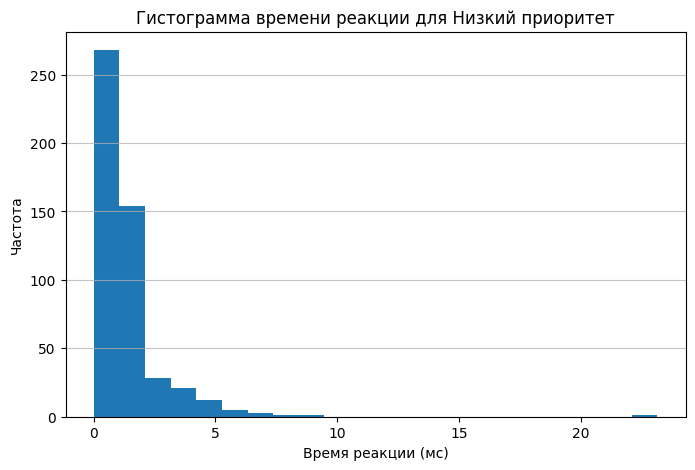

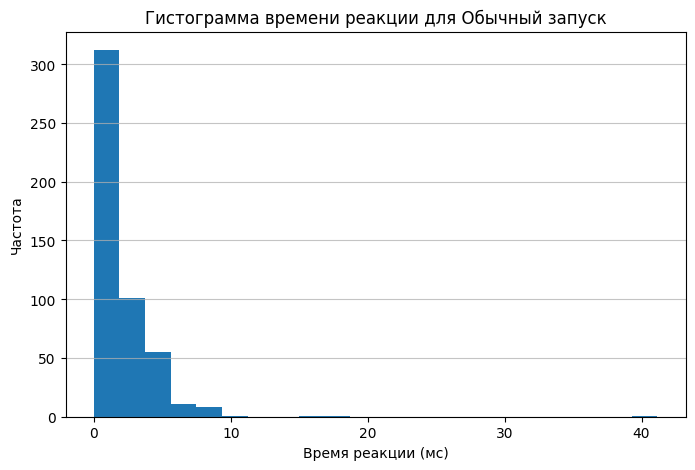

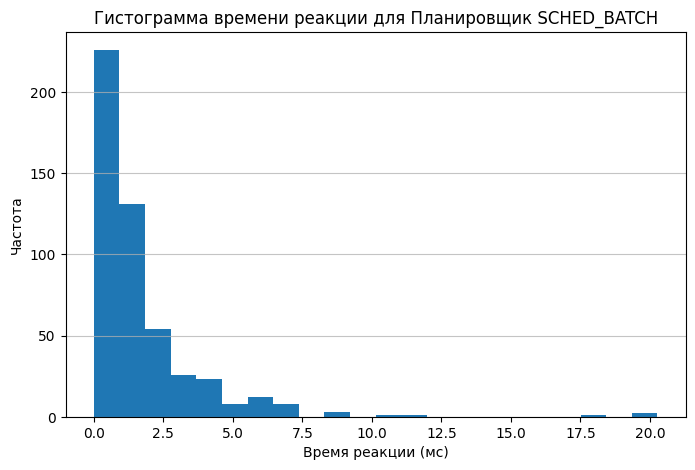

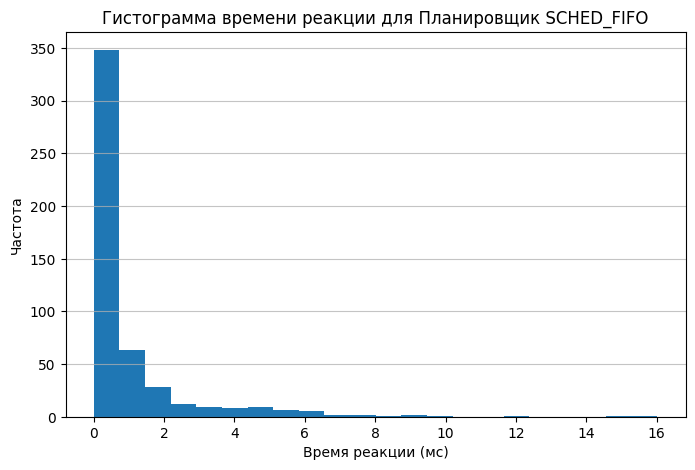

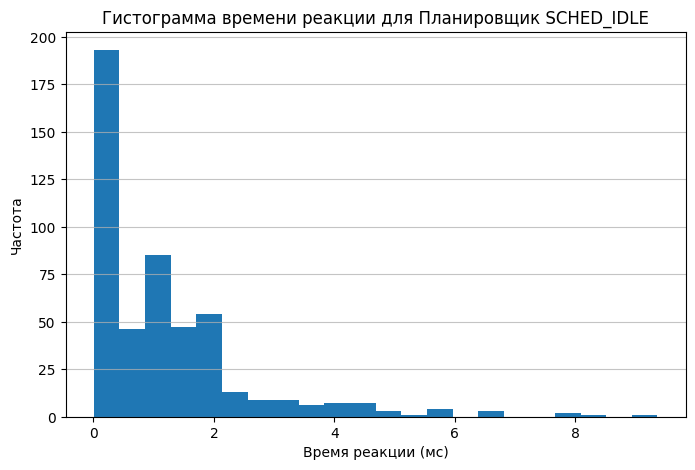

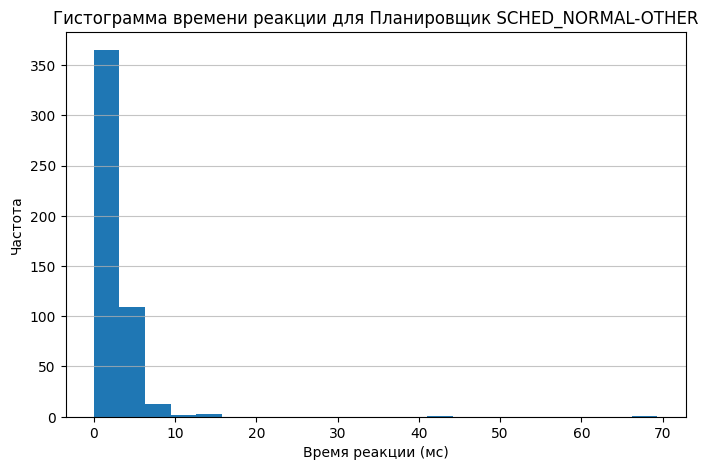

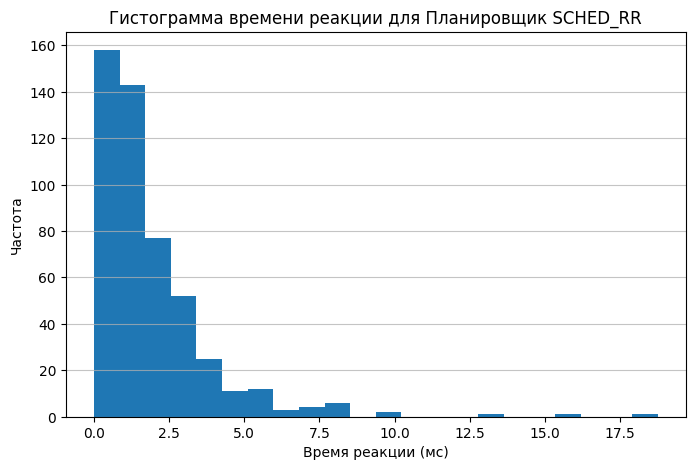

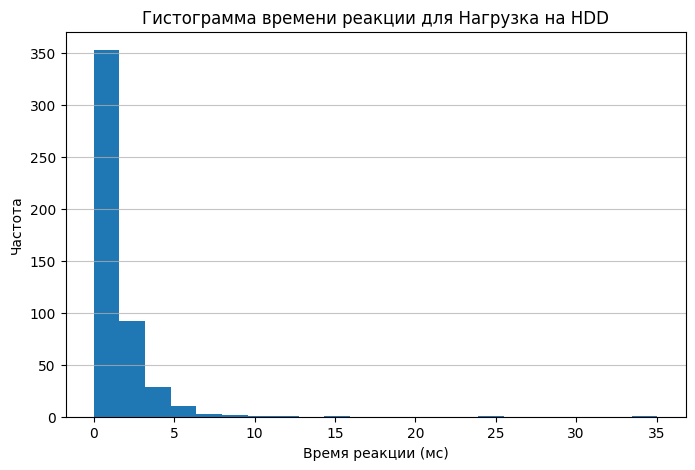

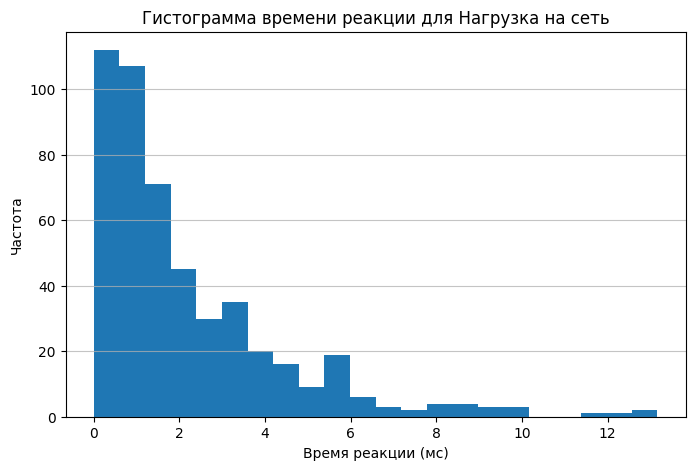

In [12]:
import re
import matplotlib.pyplot as plt
import numpy as np

def remove_outliers_iqr(data, k=1.5):
    """
    Удаляет выбросы из данных, используя метод межквартильного размаха (IQR).
    """
    data = np.array(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return filtered_data


def parse_log_data(log_content):
    """
    Parses log content to extract test names and reaction times.
    """
    tests = {}
    current_test_name = None
    test_number = 1  # Initialize test counter

    for line in log_content.splitlines():
        # Extract test name
        test_name_match = re.search(r'Тест (.*)', line)
        if test_name_match:
            current_test_name = test_name_match.group(1).strip()
            tests[current_test_name] = []
        # Check for start of a reaction time block (new test or explicit test definition)
        elif "Number of reactions is:" in line:
            if current_test_name is None:
                #If no test name specified, find a suitable name
                current_test_name = f"Тест {test_number}"
                test_number += 1
                tests[current_test_name] = []
        elif "Reaction time" in line and current_test_name:
            match = re.search(r'Reaction time \d+: (-?\d+) ns', line)
            if match:
                try:
                    time_ns = int(match.group(1))
                    tests[current_test_name].append(time_ns)
                except ValueError:
                    print(f"Не удалось преобразовать время в int: {match.group(1)}")

    return tests


def create_histograms(tests):
    """
    Creates and displays histograms for each test's reaction times.
    """
    for test_name, reaction_times in tests.items():
        print(f"\n----- {test_name} -----")
        reaction_times = np.array(reaction_times)
        reaction_times = np.delete(reaction_times,0)
        reaction_times = reaction_times[reaction_times >= 0]  # Filter negative values

        if reaction_times.size == 0:
            print(f"Нет неотрицательных значений для теста: {test_name}. Гистограмма не будет построена.")
            continue

        # Improved formatting
        max_time = reaction_times.max() / 1000000
        min_time = reaction_times.min() / 1000000
        mean_time = reaction_times.mean() /1000000

        print(f"  Макс: {max_time:.5f} мс.")
        print(f"  Мин: {min_time:.5f} мс.")
        print(f"  Среднее: {mean_time:.5f} мс.")
        
        # reaction_times = remove_outliers_iqr(reaction_times) / 1000000
        reaction_times = reaction_times / 1000000
        
        max_time = reaction_times.max()
        min_time = reaction_times.min()

        # Determine a sensible number of bins
        bins = min(100, int(np.sqrt(len(reaction_times))))

        plt.figure(figsize=(8, 5))  # Adjusted figure size
        plt.hist(reaction_times, bins=bins, range=(min_time, max_time))
        plt.title(f'Гистограмма времени реакции для {test_name}')
        plt.xlabel('Время реакции (мс)')
        plt.ylabel('Частота')
        plt.grid(axis='y', alpha=0.75)
        plt.savefig(f'{test_name}.png')
        # plt.show()

if __name__ == "__main__":
    file_path = 'Tests.txt'  # Use consistent filename
    try:
        with open(file_path, 'r', encoding='UTF-8') as file:
            log_content = file.read()
    except FileNotFoundError:
        print(f"Ошибка: Файл '{file_path}' не найден.")
        exit()

    tests = parse_log_data(log_content)
    create_histograms(tests)